In [2]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp310-cp310-linux_x86_64.whl size=661770 sha256=45b1cbb7bf1135a81298fa2dcfbbfed8f56ab5854b285423177e0f1d57a3f2b7
  Stored in directory: /root/.cache/pip/wheels/1a/1e/0d/99f55911d90f2b95b9f7c176d5813ef3622894a4b30fde6bd3
Successfully built gluonnlp


In [3]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-t1t_x4dg/kobert-tokenizer_56ba889c53be46de9d6516a74ef79c8e
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-t1t_x4dg/kobert-tokenizer_56ba889c53be46de9d6516a74ef79c8e
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4632 sha256=4841ec12cf019cb0338e86bed305ce086d0d853b14548fc3e462caef868c6f37
  Stored in directory: /tmp/pip-ephem-wheel-cache-6qt_mi_3/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f69195907a4045fe
Successfully built kobert_tokenizer


In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

/usr/local/lib/python3.10/dist-packages/mxnet/numpy/utils.py:37: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  bool = onp.bool


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
# Import
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
# GPU 사용 시
device = torch.device("cuda:0")

In [ ]:
# ★
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

데이터 전처리(다시)

In [ ]:
df=pd.read_csv('/content/yesvp_300.csv')
df

transcript  label
0    아니 제가 도대체 이게 따로 말씀드려\n은행에서 확인불가능 보고 있습니다 저희 검찰...      1
1    내 거 도쿄 중에는 이제 자금이나 제 3자 목소리가 개입되면 안 되고 지금 수사 중...      1
2    채무가 3개월 이상 쓰셔야 이제 햇살론 진행이 가능하실거든요 네네 저희 햇살론 특성...      1
3    키우냐고 5분에서 7분 정도 소요될 건데 본인 혹시 잠깐 정차 가능하신 건가요 아 ...      1
4    7시라고 해서 뭐 다른게 없고 아까 제가 연락드리면 되면 다시 한번 할 겁니다 혹시...      1
..                                                 ...    ...
312  ['여보세요', '여보세요 OOO씨 혹시 맞습니까?', '네', '저는 서울 중앙 ...      1
313  ['여보세요', '네', '네 안녕하십니까.', '혹시 OOO 핸드폰 맞으십니까?'...      1
314  ['수고하십니다.', '여기는 서울 중앙 지검이고요', '네', '저는 1,000만...      1
315  ['어 이름은 김호철이고 태어난 곳은 전라도 광주, 올해로 사십세된 남성에 농협 은...      1
316  ['네 여보세요', '네 네', '아 아 다른 게 아니라 그 OOO 본인 관련된 명...      1

[317 rows x 2 columns]

In [ ]:
# function to perform the cleaning parts
def apply_replacement(src_df, replace_func):
    ret_df = src_df
    ret_df['transcript'] = ret_df['transcript'].apply(lambda x: replace_func(x))
    return ret_df

In [ ]:
# remove the unwanted word and characters from the dataset
def word_replace(x):
    example_word_replace_list = {'o/': '',
                                 'b/': '',
                                'n/': '',
                                '\n': ' ',
                                'name': '',
                                'laughing': '',
                                'clearing': '',
                                'singing': '',
                                'applauding': ''}

    for i in example_word_replace_list:
        x = x.replace(i, example_word_replace_list[i])
    return x

In [ ]:
# remove the special character from the transcripts
def remove_special_characters(sentence):
    sentence = re.sub(r"[^a-zA-Z0-9ㄱ-ㅣ가-힣]", ' ', sentence)
    sentence = re.sub(r"[-~=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]", '', sentence)
    return sentence

In [ ]:
# remove x and O from the transcripts
def remove_x_o(sentence):
    sentence = re.sub(r"[xX]", '', sentence)
    sentence = re.sub(r"[oO]", '', sentence)
    sentence = re.sub(r"(o|O|\ㅇ|0|x){2,}", '', sentence)
    return sentence

In [ ]:
# remove all the digits and numbers from the transcripts
def remove_digits(sentence):
    sentence = re.sub(r"[0-9]", '', sentence)
    return sentence

In [ ]:
# remove all extra spaces from the transcripts
def remove_extra_spaces(sentence):
    sentence = re.sub(r"\s+", ' ', sentence)
    return sentence

In [ ]:
# Apply all the cleaning functions to the dataset
import re
df = apply_replacement(df, word_replace)
df = apply_replacement(df, remove_special_characters)
df = apply_replacement(df, remove_x_o)
df = apply_replacement(df, remove_digits)
df = apply_replacement(df, remove_extra_spaces)

In [ ]:
# print the row with any English character in the transcript
print(df[df['transcript'].str.contains('[a-zA-Z]')].head(5))

                                           transcript  label
8   일단 저희가 현 시간부로 보내 앞으로 금융권 준서 잘할 건데 이걸 하는 이유는 본인...      1
10  앞으로 발생하며 사건 때문에 연락 드렸습니다 일단 제가 몇 번 보기 전에 저희가 성...      1
15  기본이 되십니까 내일 서울중앙지법 이고요 저희 쪽에 갈비애드림 공문자 혹시 못 받으...      1
17  이 모든 녹취는 입증하기 위해 법원의 증거자료로 제출할 예정이고요네 통화는 주변 소...      1
19  통화 괜찮으신가요 실례지만 혹시 본인께서 민서라고 아시는 분인가요 모르시는 분이세요...      1


In [ ]:
# Save the preprocessed DataFrame to a new CSV file
df.to_csv("preprocessing_yesvp.csv", index=False)

In [ ]:
df=pd.read_csv('/content/novp_300.csv')
df

Unnamed: 0                                         transcript  \
0          1656  네. 혹시 최근에 다녀오신 여행지가 있으신가요? 사실 최근에는 여행지를 많이 가지 ...   
1          1412  아~ 요즘에는 반려동물을 많이 키워서 음~ 여러 가지 여러 종류의 반려동물이 많거든...   
2           480  일본에서 야마무로 신이치 교수가 혐오의 확산은 과거사 객관적인 청산 힘들게 한다 그...   
3           617  케이크 를 저는 좋아하는데요. 저는 케이크 중에 생크림 케이크를 가장 좋아합니다. ...   
4          1075  예. 저는 강아지 한 마리 키우고 있는데요. 혹시 반려동물 키우고 계세요? 저는 지...   
..          ...                                                ...   
312        1880  내가 연애에서 그렇게 크게 중요하지 않지만 그래도 항상 꿈으로 생각하는 거는 이상형...   
313         185  아~ 지금 선택한 학과에 왜 가게 됐어? 아니 사실은 디자인학과 를 처음에 고1 때...   
314         798  요즘 코로나 때문에 해외 하늘길이 막혀서 해외여행을 지금 많이 못 가고 있거든요. ...   
315         581  어~ 저는 연애 경험이 그렇게 많지는 않은데 지금까지 총 세 명의 남자 친구를 만났...   
316        1349  가족이 몇 분이세요? 우리 집은 4인 가족이에요. 남편이랑 아들이랑 딸 그렇게 4인...   

     confidence  label  
0           NaN      0  
1           NaN      0  
2           NaN      0  
3           NaN      0  
4           NaN      0  
..          ...    ...  
312         NaN      0  
313         NaN      0  
314         NaN      0  
315         NaN      0  
316         NaN      0  

[317 rows x 4 columns]

In [ ]:
# Apply all the cleaning functions to the dataset
import re
df = apply_replacement(df, word_replace)
df = apply_replacement(df, remove_special_characters)
df = apply_replacement(df, remove_x_o)
df = apply_replacement(df, remove_digits)
df = apply_replacement(df, remove_extra_spaces)

In [ ]:
# print the row with any English character in the transcript
print(df[df['transcript'].str.contains('[a-zA-Z]')].head(5))

     Unnamed: 0                                         transcript  \
125          69  네 씨는 혹시 여행 좋아하시나요 저는 되게 많이 좋아합니다 국내 해외 다 좋아하고 ...   

     confidence  label  
125         NaN      0  


In [ ]:
df

Unnamed: 0                                         transcript  \
0          1656  네 혹시 최근에 다녀오신 여행지가 있으신가요 사실 최근에는 여행지를 많이 가지 못했...   
1          1412  아 요즘에는 반려동물을 많이 키워서 음 여러 가지 여러 종류의 반려동물이 많거든요 ...   
2           480  일본에서 야마무로 신이치 교수가 혐오의 확산은 과거사 객관적인 청산 힘들게 한다 그...   
3           617  케이크 를 저는 좋아하는데요 저는 케이크 중에 생크림 케이크를 가장 좋아합니다 저는...   
4          1075  예 저는 강아지 한 마리 키우고 있는데요 혹시 반려동물 키우고 계세요 저는 지금은 ...   
..          ...                                                ...   
312        1880  내가 연애에서 그렇게 크게 중요하지 않지만 그래도 항상 꿈으로 생각하는 거는 이상형...   
313         185  아 지금 선택한 학과에 왜 가게 됐어 아니 사실은 디자인학과 를 처음에 고 때 지망...   
314         798  요즘 코로나 때문에 해외 하늘길이 막혀서 해외여행을 지금 많이 못 가고 있거든요 그...   
315         581  어 저는 연애 경험이 그렇게 많지는 않은데 지금까지 총 세 명의 남자 친구를 만났어...   
316        1349  가족이 몇 분이세요 우리 집은 인 가족이에요 남편이랑 아들이랑 딸 그렇게 인 가족이...   

     confidence  label  
0           NaN      0  
1           NaN      0  
2           NaN      0  
3           NaN      0  
4           NaN      0  
..          ...    ...  
312         NaN      0  
313         NaN      0  
314         NaN      0  
315         NaN      0  
316         NaN      0  

[317 rows x 4 columns]

In [ ]:
df

Unnamed: 0                                         transcript  label
0          1656  네 혹시 최근에 다녀오신 여행지가 있으신가요 사실 최근에는 여행지를 많이 가지 못했...      0
1          1412  아 요즘에는 반려동물을 많이 키워서 음 여러 가지 여러 종류의 반려동물이 많거든요 ...      0
2           480  일본에서 야마무로 신이치 교수가 혐오의 확산은 과거사 객관적인 청산 힘들게 한다 그...      0
3           617  케이크 를 저는 좋아하는데요 저는 케이크 중에 생크림 케이크를 가장 좋아합니다 저는...      0
4          1075  예 저는 강아지 한 마리 키우고 있는데요 혹시 반려동물 키우고 계세요 저는 지금은 ...      0
..          ...                                                ...    ...
312        1880  내가 연애에서 그렇게 크게 중요하지 않지만 그래도 항상 꿈으로 생각하는 거는 이상형...      0
313         185  아 지금 선택한 학과에 왜 가게 됐어 아니 사실은 디자인학과 를 처음에 고 때 지망...      0
314         798  요즘 코로나 때문에 해외 하늘길이 막혀서 해외여행을 지금 많이 못 가고 있거든요 그...      0
315         581  어 저는 연애 경험이 그렇게 많지는 않은데 지금까지 총 세 명의 남자 친구를 만났어...      0
316        1349  가족이 몇 분이세요 우리 집은 인 가족이에요 남편이랑 아들이랑 딸 그렇게 인 가족이...      0

[317 rows x 3 columns]

In [ ]:
# Save the preprocessed DataFrame to a new CSV file
df.to_csv("preprocessing_novp.csv", index=False)

# data import

In [ ]:
# Load the cleaned dataset
import pandas as pd
df = pd.read_csv('merged_data.csv')

dataset split

In [ ]:
#train/test data split
from sklearn.model_selection import train_test_split

# Load the cleaned dataset
df = pd.read_csv('merged_data.csv')

# Split the dataset into train and test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Display the shape of train and test datasets
print("Train dataset shape:", df_train.shape)
print("Test dataset shape:", df_test.shape)



Train dataset shape: (507, 3)
Test dataset shape: (127, 3)


In [ ]:
df_train

Unnamed: 0                                         transcript  label
487         NaN   네 네 여보세요 뭐 어디세요 아 네 안녕하세요 저희 그 하나캐피탈에서 연락을 드렸...      1
421         NaN   여보세요 안녕하세요 고객님 김종현 대리입니다 아네 대리님 고객님 연락이 너무 안되...      1
104      1211.0  지금까지 받은 선물 중에 가장 기억에 남는 선물이 뭐가 있나요 제가 받은 선물 중에...      0
114      1163.0  요즘에는 대가 지나가니까 나이가 들어서인지 몸이 이쪽 저쪽으로 쑤시고 밤에 꼭 새벽...      0
349         NaN  이 사건에 대해서 개인정보보호법 열거하여 주민번호 계좌번호 비밀번호 등은 절대 먹지...      1
..          ...                                                ...    ...
71       1549.0  너는 지금 반려동물이 키우고 있니 응 나는 고양이 두 마리를 키우고 있어 코리안숏헤...      0
106       350.0   씨는 어떤 날씨를 좋아해요 저는 많이 생각해보지 않았는데 지금 생각해보면 어떤 날...      0
270      1290.0  국가재난지원금 가장 많이 쓴 데가 어딘지 알아 요즘 있잖아 그 반려동물을 진짜 그렇...      0
435         NaN   네 네 여보세요 뭐 어디세요 아 네 안녕하세요 저희 그 하나캐피탈에서 연락을 드렸...      1
102       211.0  혹시 요즘 가지고 있는 취미가 뭐가 있어 일단 첫 번째는 낚시가 있는데 이제 나는 ...      0

[507 rows x 3 columns]

In [ ]:
df_test

Unnamed: 0                                         transcript  label
396         NaN  아 그래요 광고를 한 상태고요 신용카드 리폼을 안 했는데 지금 통화 여기 발견이 되...      1
248       416.0  가장 좋아하는 음식 있으신가요 저는 가장 좋아하는 음식이라고 딱 꼽을 순 없는데 음...      0
215       990.0  브라질 인구가 미국하고 거의 비슷한 걸로 알고 있는데 그런가 전혀 모르고 있었는데 ...      0
353         NaN  신경 편집이라는게 어떤 방법으로 당일 날 바로 사용 시킨 거 불가능거든요 그렇기 때...      1
548         NaN   어 이름은 김호철이고 태어난 곳은 전라도 광주 올해로 사십세된 남성에 농협 은행에...      1
..          ...                                                ...    ...
556         NaN   아 서울 중앙 지검 첨단 범죄 수사 일부 이희나 수사관입니다 본 사건 조사는 법원...      1
265       174.0   님한테 가족이라는 것은 어떤 의미인지 가족을 어떻게 정의하고 있는지 말씀해 주세요...      0
473         NaN   여보세요 안녕하세요 고객님 김종현 대리입니다 아네 대리님 고객님 연락이 너무 안되...      1
464         NaN   여보세요 네 삐 삐 님 예 예 어저께 통화했던 최영환입니다 아 예 예 어떻게 가진...      1
340         NaN  대포 통장이 계좌로 발견되다 자기가 먼저 연락을 드렸고요 발견돼서 연락드렸어요 농협...      1

[127 rows x 3 columns]

In [ ]:
texts = df_train['transcript'].values
texts

array([' 네 네 여보세요 뭐 어디세요 아 네 안녕하세요 저희 그 하나캐피탈에서 연락을 드렸습니다 아 그래요 네네네 고객님께서 이제 중개업체쪽에서 필요 자금 부분 신청하신 건 때문에 연락을 드린거구요 지금 현재 이용중이신 고금리건 채무 러시앤캐시 산와머니 이런 고금리건 채무 이용하시는 부분들 이하대 전환대안대출로 좀 연락을 드렸습니다 아 그래요 네네 지금 보시면 이제 신용 등급 부분하고는 관계없이 저희쪽에서 연 이자 이하대에 저금리 대안상품으로 바꿔드림론 이런 상품으로 정부지원상품으로 지원차 연락을 좀 드린거고 현재 이용중이신 고금리건 어디어디 이용중이시죠 많이 있죠 네네 어디어디 이용중이십니까 너무 많아가지고 네 대부업건 어디어디 이용중이세요 얼만지 제가 한번 보고 전화를 한번 드릴게요 아 네 알겠습니다 그 바로 연락 한번 좀 부탁드릴게요 알겠습니다 ',
       ' 여보세요 안녕하세요 고객님 김종현 대리입니다 아네 대리님 고객님 연락이 너무 안되셔가지고 지금 아 네 제가 너무 바빠서요 아 지금은 좀 연락이 이제 가능하신 건가요 아네네 대리님 그 남의 돈 드시니까 좋으세요 네 무슨말씀이시죠 아 제가 보니까 제게 상환이 다 안되있더라구요 상환이 안되셨다구요 네네 어디가 상환이 안되셨다는 거죠 아 제거 KB국민은행에 상환이 다 안되있던데요 고객센터에서 알아보신 건가요 네 어디에 상환하신거 수요일에 상환하신 아닌데 잠시만요 목요일날 상환하신거 말씀하신거죠 네 그게 지금 고객센터로 넘어가는게 좀 서류가 늦게 들어가서 확인이 안되실수도 있으세요 어떻게 기록삭제가 바로되는데 확인이 안돼요 그쪽에서 기록삭제 하고 납부하셨잖아요 네 납부가 완료 되셨잖아요 그럼 그쪽 전산망으로 이제 고객센터한테 보내야 돼요 서류를 그부분이 목요일날 이 수요일이 빨간날이였잖아요 네 그래가지고 그게 아마 밀리셔가지고 오늘까지 안되시면 아마 월요일까지 고객센터 확인이 가능하신 부분이세요 음 그렇구나 대리님 네 사기치지 마시고요 다른사람한테 피해주지 마시구요 그러다 벌받아요 무슨소리하시는

Model


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup

# 데이터 로드
df = pd.read_csv("/content/merged_data.csv")

# 레이블 및 텍스트 추출
labels = df['label'].values
texts = df['transcript'].values

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)  # Change to long for classification
        }

# 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')
model = BertForSequenceClassification.from_pretrained('monologg/kobert', num_labels=2)  # Change num_labels to 2 for binary classification

# 데이터 분할
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.1, random_state=42)

# 데이터셋 및 DataLoader 생성
max_len = 64  # 적절한 시퀀스 길이로 조정
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_len)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# 옵티마이저 및 스케줄러 설정
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 4
num_training_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
criterion = torch.nn.CrossEntropyLoss()  # Use cross-entropy loss for classification

# 훈련 루프
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    # 훈련
    model.train()
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # 검증
    model.eval()
    val_predictions = []
    val_true_labels = []
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs} - Validation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1).cpu().numpy()  # Use argmax for classification

            val_predictions.extend(predictions)
            val_true_labels.extend(labels.cpu().numpy())

    # 평가
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    print(f'Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {val_accuracy}')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/4 - Validation: 100%|██████████| 32/32 [00:01<00:00, 31.04it/s]


Epoch 1/4 - Validation Accuracy: 0.90625


Epoch 2/4 - Validation: 100%|██████████| 32/32 [00:01<00:00, 31.74it/s]


Epoch 2/4 - Validation Accuracy: 0.890625


Epoch 3/4 - Validation: 100%|██████████| 32/32 [00:00<00:00, 32.86it/s]


Epoch 3/4 - Validation Accuracy: 0.890625


Epoch 4/4 - Validation: 100%|██████████| 32/32 [00:00<00:00, 32.13it/s]

Epoch 4/4 - Validation Accuracy: 0.921875


In [ ]:
import os

# 저장 경로 설정
output_dir = '/content/saved_model/'
os.makedirs(output_dir, exist_ok=True)

# 모델 저장
model.save_pretrained(output_dir)

# 토크나이저 저장 (필요시)
tokenizer.save_pretrained(output_dir)

# 옵티마이저 및 스케줄러 상태 저장
checkpoint = {
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'epoch': epoch,
    'model_state_dict': model.state_dict()
}

torch.save(checkpoint, os.path.join(output_dir, 'checkpoint.pth'))


confusion matrix


Testing: 100%|██████████| 317/317 [00:12<00:00, 24.99it/s]


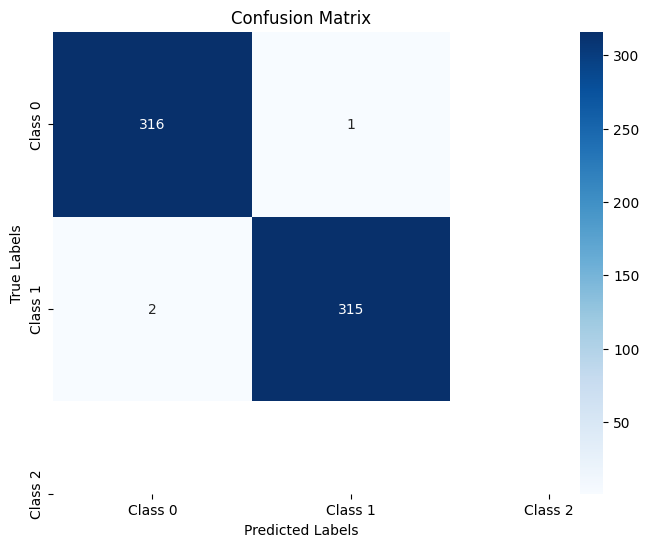

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드
df = pd.read_csv("/content/merged_data.csv")

# 레이블 및 텍스트 추출
labels = df['label'].values
texts = df['transcript'].values

# 테스트 데이터셋 및 DataLoader 생성
test_dataset = CustomDataset(texts, labels, tokenizer, max_len)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)


# 테스트 데이터셋을 이용하여 예측 수행
model.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='Testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).cpu().numpy()

        test_predictions.extend(predictions)
        test_true_labels.extend(labels.cpu().numpy())

# Confusion Matrix 생성
conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# Heatmap을 이용하여 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


하이퍼파라미터 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Assuming you have your own dataset (texts, labels)
# Replace the following lines with your dataset loading
df = pd.read_csv("/content/merged_data.csv")
labels = df['label'].values
texts = df['transcript'].values

# Tokenize the texts using Kobert tokenizer
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')
tokenized_texts = [tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128) for text in texts]

# Convert BERT embeddings to numpy arrays
bert_model = BertModel.from_pretrained('monologg/kobert')
embeddings = [bert_model(**text).last_hidden_state.mean(dim=1).detach().numpy() for text in tokenized_texts]
X = np.vstack(embeddings)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Initialize your model
model = SVC()

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.01, 0.1, 1, 'scale']
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model on the test set
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")


Best Hyperparameters: {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
Test Accuracy: 0.968503937007874


predict.py

In [ ]:
from transformers import BertTokenizer
import torch
import numpy as np

# Hugging Face의 미리 훈련된 KoBERT 토크나이저를 로드합니다.
tokenizer = BertTokenizer.from_pretrained("monologg/kobert")

max_len = 128  # 미세 조정 중 사용한 max_len과 동일하게 설정합니다.

from transformers import BertForSequenceClassification, BertTokenizer

# 저장된 모델과 토크나이저 불러오기
loaded_model = BertForSequenceClassification.from_pretrained('/content/saved_model')
loaded_tokenizer = BertTokenizer.from_pretrained('/content/saved_model')

class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len):
        self.tokenizer = bert_tokenizer
        self.max_len = max_len
        self.sentences = [i[sent_idx] for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        sentence, label = self.sentences[i], self.labels[i]
        encoding = self.tokenizer(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()
        return input_ids, attention_mask, label

    def __len__(self):
        return len(self.labels)

def predict(predict_sentence):
    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, max_len)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=1, num_workers=5)

    loaded_model.eval()

    for input_ids, attention_mask, label in test_dataloader:
        with torch.no_grad():
            outputs = loaded_model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=1).squeeze().numpy()

        # 확률 출력
        print("예측된 확률:", probabilities)

        # 확률에 따라 클래스 분류
        if probabilities[0] > 0.5:
            safety_level = '일반 대화'
        else:
            safety_level = '보이스피싱'

        # 예측된 클래스 출력
        print("예측된 클래스:", safety_level)

        return probabilities, safety_level


In [ ]:
# 예측할 문장
predict_sentence = "네 네 여보세요 뭐 어디세요 아 네 안녕하세요 저희 그 하나캐피탈에서 연락을 드렸습니다 아 그래요 네네네 고객님께서 이제 중개업체쪽에서 필요 자금 부분 신청하신 건 때문에 연락을 드린거구요 지금 현재 이용중이신 고금리건 채무 러시앤캐시 산와머니 이런 고금리건 채무 이용하시는 부분들 이하대 전환대안대출로 좀 연락을 드렸습니다 아 그래요 네네 지금 보시면 이제 신용 등급 부분하고는 관계없이 저희쪽에서 연 이자 이하대에 저금리 대안상품으로 바꿔드림론 이런 상품으로 정부지원상품으로 지원차 연락을 좀 드린거고 현재 이용중이신 고금리건 어디어디 이용중이시죠 많이 있죠 네네 어디어디 이용중이십니까 너무 많아가지고 네 대부업건 어디어디 이용중이세요 얼만지 제가 한번 보고 전화를 한번 드릴게요 아 네 알겠습니다 그 바로 연락 한번 좀 부탁드릴게요 알겠습니다"

# predict 함수 호출
probabilities, predicted_class = predict(predict_sentence)

# 출력 확인
print("예측된 확률:", probabilities)
print("예측된 클래스:", predicted_class)


예측된 확률: [0.00868241 0.99131763]
예측된 클래스: 보이스피싱
예측된 확률: [0.00868241 0.99131763]
예측된 클래스: 보이스피싱
